<a href="https://colab.research.google.com/github/devparikh0506/DATA-602/blob/main/week_13/Homework_Week_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 13

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

## Loading the datasets

In [4]:
 import tensorflow_datasets as tfds

In [5]:
(train_ds, val_ds), info = tfds.load(
        'rock_paper_scissors',
        split=['train[:80%]', 'train[80%:]'],
        with_info=True,
        as_supervised=True
    )

class_names = info.features['label'].names

print(f"Class Names: {class_names}")
print(f"Total Training Images: {info.splits['train'].num_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PJXGI4_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PJXGI4_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Class Names: ['rock', 'paper', 'scissors']
Total Training Images: 2520


# Preprocessing data

In [6]:
def prepare_dataset(ds, shuffle=True, batch_size=32):
  ds = ds.map(
      lambda x, y: (tf.image.resize(x, (224, 224)), y),
      num_parallel_calls=tf.data.AUTOTUNE
  )
  if shuffle:
      ds = ds.shuffle(1000)
  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [7]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds, shuffle=False)

## Let's create model

### First create data augmentation layer

In [8]:
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

This augmentation layer applies random transformations to the input images, including horizontal flipping, rotation (up to 20%), zooming (up to 20%), and contrast adjustment (up to 20%). These augmentations help create variability in the training data to improve the model's robustness and generalization.

In [9]:
num_classes = len(class_names)
input_shape = (224, 224, 3)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation_layer,
    # Resizing input to match MobileNetV2 expected input
    layers.Resizing(224, 224),
    # Normalizing pixel values
    layers.Rescaling(1./255),
    base_model,
    # Global average pooling
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

This model uses a pretrained MobileNetV2 backbone for feature extraction, preceded by resizing and rescaling layers to preprocess the input images. It includes a Global Average Pooling layer, followed by two dense layers with dropout for regularization. The final dense layer outputs predictions for three gesture classes: rock, paper, and scissors. Only the dense layers are trainable, while the MobileNetV2 layers remain frozen.

### Training the model

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.4839 - loss: 1.6263 - val_accuracy: 0.9405 - val_loss: 0.7737 - learning_rate: 1.0000e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8220 - loss: 0.8975 - val_accuracy: 0.9683 - val_loss: 0.6023 - learning_rate: 1.0000e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8836 - loss: 0.7213 - val_accuracy: 0.9821 - val_loss: 0.5391 - learning_rate: 1.0000e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9086 - loss: 0.6875 - val_accuracy: 0.9841 - val_loss: 0.4958 - learning_rate: 1.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9324 - loss: 0.5952 - val_accuracy: 0.9841 - val_loss: 0.4759 - learning_rate: 1.0000e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9357 - loss: 0.5699 - val_accuracy: 0.9881 - val_loss: 0.4527 - learning_rate: 1.0000e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.

# Plotting results

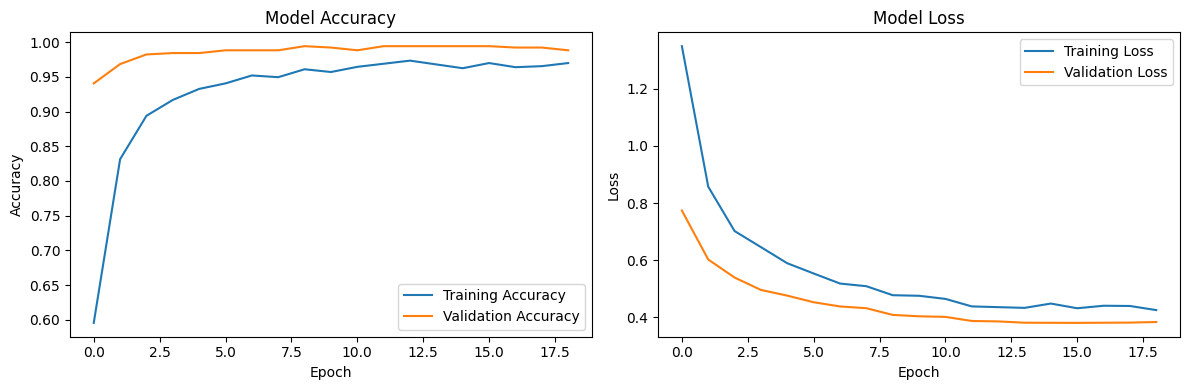

In [13]:
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [23]:
y_true = []
y_pred = []

# Iterate through validation dataset to get true labels and predictions
for images, labels in val_ds:
    pred = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(pred, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [24]:
overall_accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Macro and Weighted Averages
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print Results
print("\n--- Accuracy Metrics ---")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

print("\nClass-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")

print("\nAggregate Metrics:")
print(f"Macro Precision:  {precision_macro:.4f}")
print(f"Macro Recall:     {recall_macro:.4f}")
print(f"Macro F1-Score:   {f1_macro:.4f}")

print(f"\nWeighted Precision:  {precision_weighted:.4f}")
print(f"Weighted Recall:     {recall_weighted:.4f}")
print(f"Weighted F1-Score:   {f1_weighted:.4f}")

print("\nConfusion Matrix:")
print(cm)

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



--- Accuracy Metrics ---
Overall Accuracy: 0.9940

Class-wise Metrics:

ROCK:
  Precision: 1.0000
  Recall:    0.9936
  F1-Score:  0.9968

PAPER:
  Precision: 0.9942
  Recall:    0.9884
  F1-Score:  0.9913

SCISSORS:
  Precision: 0.9887
  Recall:    1.0000
  F1-Score:  0.9943

Aggregate Metrics:
Macro Precision:  0.9943
Macro Recall:     0.9940
Macro F1-Score:   0.9941

Weighted Precision:  0.9941
Weighted Recall:     0.9940
Weighted F1-Score:   0.9940

Confusion Matrix:
[[156   1   0]
 [  0 170   2]
 [  0   0 175]]

Detailed Classification Report:
              precision    recall  f1-score   support

        rock       1.00      0.99      1.00       157
       paper       0.99      0.99      0.99       172
    scissors       0.99      1.00      0.99       175

    accuracy                           0.99       504
   macro avg       0.99      0.99      0.99       504
weighted avg       0.99      0.99      0.99       504

